In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

### Load modules

In [ ]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread # you may see a version error on the first run - the code will still run
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

# data processing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Bayesian Package
import pymc3 as pm
from pymc3 import *
print(f"Running on PyMC3 v{pm.__version__}")

import itertools
from scipy.stats.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import arviz as az

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
Running on PyMC3 v3.11.4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Import Data from Sheets or BigQuery

## From Sheets

In [ ]:
#@title Parameters

INPUT_SHEET_NAME = 'sample_data' #@param {type:"string"}

In [ ]:

worksheet = gc.open(INPUT_SHEET_NAME).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df=pd.DataFrame.from_records(rows)


#get column names from first row
df.columns = df.iloc[0]

#drop row with column names
df = df.drop(df.index[0])

#reset indexes
df = df.reset_index(drop=True)

#convert numeric data to numeric types
df = df.apply(pd.to_numeric, errors='ignore')

In [ ]:
df.head()

,geo,date,y1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,Northeast,2017-09-04 00:00:00+00:00,2258,48295480,1789,14961,21321,2934,27861,23083,1.20302,11457,9726,3276,3263,7659,2170,7127,433,43,44079352,5485207,4028351,16696516,8083962,6398572,608760,2837865,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,0,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,Northeast,2017-09-05 00:00:00+00:00,3140,46867144,2017,19883,26379,3525,32136,32550,0.95112,13388,12898,4059,3662,9214,2500,10173,471,42,47565640,6891432,3754244,16118995,9395026,6312236,667357,3817186,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,0,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,Northeast,2017-09-08 00:00:00+00:00,2253,52946853,1872,17798,23043,2807,28748,28317,0.98481,11652,11017,3233,3319,7828,2353,9568,421,84,39433266,5956677,2962264,9950959,9528970,6361696,758584,2716435,357525,862526,0,2309881,115646,107146,421895,7510168,1219954,1199804,0,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,Northeast,2017-09-09 00:00:00+00:00,1888,51527610,1800,15383,21023,3091,27638,24246,1.16516,11554,9253,3306,2986,7400,2072,7646,422,78,34986121,5118162,2602023,9165565,7659374,6107525,627391,2484630,309679,798040,0,1801605,122723,108494,403645,7578970,1283406,1514418,0,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,Northeast,2017-09-10 00:00:00+00:00,1623,51572539,2040,18561,24385,2943,30874,28190,1.11976,13852,10122,3476,3183,9850,2121,8437,433,88,38834976,5996156,2800133,10962081,7866840,6491669,593808,2594647,406079,727476,0,2142987,117797,112672,372197,8604309,1081421,1516359,0,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


In [ ]:
len(df.columns)

49

# Data Cleaning

Keep only necessary columns

In [ ]:
df.describe()

,y1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,2250.15321,43017370.60297,1983.75453,9502.77100,21480.94563,1998.41680,24959.23394,21734.89786,1.21983,11313.50741,9823.90115,2353.00494,4147.06590,4761.00659,3276.47611,4718.88797,311.25206,14.62273,44776320.21582,11625655.02471,3266837.68699,12520730.45470,7502064.20593,7503926.02142,800819.09390,1500965.74629,98879.23229,565270.65239,79538.84843,4397846.13674,103429.12356,103455.26359,232131.82537,10222483.63427,1251220.30807,2935893.03130,0.01647,579577.02801,629286.96211,2203550.21582,768464.30148,7349729.80890,3258401.86326,134927.09061,5758483.16804,562753.05437,526326.02636
std,461.35767,11041200.04201,304.29414,2917.87708,2305.48727,973.92067,2243.19098,4067.72694,0.29786,1355.41852,1155.54966,975.56904,702.65287,1441.56411,626.70092,1560.05009,161.98211,23.78516,12529786.01959,6378750.11026,1612338.39983,4046882.93296,2720420.80268,3032776.72663,258439.96637,632583.61873,115048.34158,491736.52382,330362.71054,2807112.93335,70913.71109,70656.86459,126717.52348,3042437.80485,704994.41118,2214740.24515,0.40589,272502.95446,656588.69512,479677.52536,259129.80186,2712473.38316,1615738.65995,140461.95610,4002110.54216,446515.11749,530072.46490
min,1159.00000,16444400.00000,1212.00000,5669.00000,15223.00000,0.00000,18347.00000,13897.00000,0.75973,8146.00000,6488.00000,808.00000,2555.00000,2475.00000,1764.00000,2562.00000,0.00000,0.00000,17066775.00000,3328449.00000,0.00000,4356972.00000,2618008.00000,2216280.00000,0.00000,386411.00000,0.00000,0.00000,0.00000,918921.00000,0.00000,0.00000,0.00000,3350974.00000,291854.00000,0.00000,0.00000,0.00000,0.00000,861858.00000,0.00000,2201342.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1924.00000,35459529.00000,1787.00000,7296.50000,19855.00000,1121.00000,23432.50000,18349.00000,0.98585,10240.00000,8993.00000,1475.00000,3597.50000,3554.00000,2828.50000,3575.00000,257.50000,5.00000,35817512.00000,7673570.50000,2356626.00000,9625521.50000,5707554.50000,5224997.50000,712985.00000,1156013.50000,0.00000,236067.00000,0.00000,2149083.00000,73754.00000,72877.00000,130867.50000,8219412.00000,692688.00000,1381817.50000,0.00000,415833.50000,221757.00000,2076953.50000,636682.50000,5595286.50000,2385656.50000,0.00000,4004452.00000,291539.00000,247696.00000
50%,2227.00000,42908974.00000,1957.00000,8455.00000,21373.00000,2017.00000,24824.00000,21768.00000,1.12697,11411.00000,9868.00000,2327.00000,4094.00000,4482.00000,3280.00000,4124.00000,347.00000,8.00000,42319673.00000,9733833.00000,3302945.00000,12109219.00000,6995453.00000,6491669.00000,797043.00000,1373219.00000,51982.00000,469503.00000,51943.00000,3074997.00000,103344.00000,104647.00000,206513.00000,9669682.00000,1055786.00000,2271089.00000,0.00000,481875.00000,350079.00000,2289272.00000,769383.00000,6828403.00000,3288012.00000,113893.00000,4847731.00000,457440.00000,341713.00000
75%,2459.00000,49907341.50000,2157.00000,11388.50000,23064.50000,2672.00000,26364.00000,24880.50000,1.43795,12319.00000,10598.50000,3040.00000,4609.50000,5456.50000,3734.50000,5731.50000,426.00000,14.00000,50754443.50000,12583551.50000,4329562.50000,14714574.00000,8489930.00000,9820235.50000,889449.50000,1690233.00000,181609.50000,881088.00000,92216.00000,6533253.50000,134778.00000,137073.50000,315230.00000,11580379.00000,1725023.50000,3626790.50000,0.00000,723718.00000,893655.50000,2495785.00000,864292.50000,82983

## Step 1: Handling Missing Data

In [ ]:
# Determine number of missing values
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

x46    0.00000
x21    0.00000
x19    0.00000
x18    0.00000
x17    0.00000
x16    0.00000
x15    0.00000
x14    0.00000
x13    0.00000
x12    0.00000
x11    0.00000
x10    0.00000
x9     0.00000
x8     0.00000
x7     0.00000
x6     0.00000
x5     0.00000
x4     0.00000
x3     0.00000
x2     0.00000
x1     0.00000
y1     0.00000
date   0.00000
x20    0.00000
x22    0.00000
x45    0.00000
x23    0.00000
x44    0.00000
x43    0.00000
x42    0.00000
x41    0.00000
x40    0.00000
x39    0.00000
x38    0.00000
x37    0.00000
x36    0.00000
x35    0.00000
x34    0.00000
x33    0.00000
x32    0.00000
x31    0.00000
x30    0.00000
x29    0.00000
x28    0.00000
x27    0.00000
x26    0.00000
x25    0.00000
x24    0.00000
geo    0.00000
dtype: float64

In [ ]:
# Determine percent of zeros by column
num_zeros = (100*df[df == 0].count(axis=0)/len(df.index))
num_zeros.sort_values(ascending = False)

x36    99.83526
x26    49.58814
x43    34.92586
x28    28.17133
x27    21.58155
x31    18.61614
x30    18.61614
x17    16.80395
x16    14.16804
x38    11.53213
x42    7.90774 
x20    7.90774 
x44    6.58979 
x35    5.76606 
x24    0.98847 
x45    0.98847 
x32    0.98847 
x37    0.98847 
x40    0.98847 
x5     0.32949 
x46    0.16474 
x8     0.00000 
x9     0.00000 
x7     0.00000 
x10    0.00000 
x3     0.00000 
x6     0.00000 
x4     0.00000 
x12    0.00000 
x2     0.00000 
x1     0.00000 
y1     0.00000 
date   0.00000 
x11    0.00000 
x22    0.00000 
x13    0.00000 
x14    0.00000 
x15    0.00000 
x18    0.00000 
x19    0.00000 
x21    0.00000 
x23    0.00000 
x25    0.00000 
x29    0.00000 
x33    0.00000 
x34    0.00000 
x39    0.00000 
x41    0.00000 
geo    0.00000 
dtype: float64

### Option to drop columns with high percentage of missing data

In [ ]:
#@title Set threshold for missing data

remove_missing_vals = "Yes" #@param {type: "string"}
missing_value_threshold = 50 #@param {type:"integer"}


In [ ]:
missing_value_threshold_cols = []

if remove_missing_vals == "Yes":
  for i in missing_values[missing_values >= missing_value_threshold].index:
    missing_value_threshold_cols += i
    df.drop(columns = i, inplace = True)
else:
  print('No columns dropped')

print('Remaining columns:',df.columns)

Remaining columns: Index(['geo', 'date', 'y1', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18',
       'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38',
       'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46'],
      dtype='object')


### Option to drop columns with high percentage of zeros in data

In [ ]:
#@title Set threshold for number of zeros in the data

remove_highzero_vals = "Yes" #@param {type: "string"}
highzero_value_threshold = 50 #@param {type:"integer"}


In [ ]:
highzero_value_threshold_cols = []

if remove_highzero_vals == "Yes":
  for i in num_zeros[num_zeros >= highzero_value_threshold].index:
    highzero_value_threshold_cols += i
    df.drop(columns = i, inplace = True)
else:
  print('No columns dropped')

print('Remaining columns:',df.columns)

Remaining columns: Index(['geo', 'date', 'y1', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18',
       'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46'],
      dtype='object')


### Imputing Missing Data

In [ ]:
#@title Define Imputation Method

# Imputation Method: Mean value, Median Value, Zero
imputation_method = 'Zero' #@param {type:"string"}


In [ ]:
if imputation_method == 'mean value':
  df.fillna(df.mean(), inplace = True)
elif imputation_method == 'median value':
  df.fillna(df.median(), inplace = True)
elif imputation_method == 'Zero':
  df.fillna(0, inplace = True)
else:
  df.fillna(0, inplace = True)


### Identify & drop columns with all 0's 


Constant variance violates model assumptions

The goal of printing the null_list below is to check alignment with the media buy.

In [ ]:
df.columns

Index(['geo', 'date', 'y1', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18',
       'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46'],
      dtype='object')

In [ ]:
# Identify columns with all 0's
col_nulls = df.loc[:, (df == 0).all()]
null_list = list(col_nulls.columns) 
null_list # check alignment with media buy 

# Drop columns with all 0's
df.drop(null_list, axis=1, inplace=True)
print("Columns dropped")

Columns dropped


## Step 2: Define date and Y (KPI column), create initial feature set

In [ ]:
df.head()

,geo,date,y1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,Northeast,2017-09-04 00:00:00+00:00,2258,48295480,1789,14961,21321,2934,27861,23083,1.20302,11457,9726,3276,3263,7659,2170,7127,433,43,44079352,5485207,4028351,16696516,8083962,6398572,608760,2837865,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,Northeast,2017-09-05 00:00:00+00:00,3140,46867144,2017,19883,26379,3525,32136,32550,0.95112,13388,12898,4059,3662,9214,2500,10173,471,42,47565640,6891432,3754244,16118995,9395026,6312236,667357,3817186,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,Northeast,2017-09-08 00:00:00+00:00,2253,52946853,1872,17798,23043,2807,28748,28317,0.98481,11652,11017,3233,3319,7828,2353,9568,421,84,39433266,5956677,2962264,9950959,9528970,6361696,758584,2716435,357525,862526,0,2309881,115646,107146,421895,7510168,1219954,1199804,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,Northeast,2017-09-09 00:00:00+00:00,1888,51527610,1800,15383,21023,3091,27638,24246,1.16516,11554,9253,3306,2986,7400,2072,7646,422,78,34986121,5118162,2602023,9165565,7659374,6107525,627391,2484630,309679,798040,0,1801605,122723,108494,403645,7578970,1283406,1514418,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,Northeast,2017-09-10 00:00:00+00:00,1623,51572539,2040,18561,24385,2943,30874,28190,1.11976,13852,10122,3476,3183,9850,2121,8437,433,88,38834976,5996156,2800133,10962081,7866840,6491669,593808,2594647,406079,727476,0,2142987,117797,112672,372197,8604309,1081421,1516359,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


In [ ]:
#@title Input column names for date (ex: "day") and Y (ex: "new_accounts" or "sales") 

DATE_COL = "date" #@param {type: "string"}
KPI_COL = "y1" #@param {type: "string"}


In [ ]:
cols = [col for col in df.columns]
featureset_df = df[cols]
featureset_df = featureset_df.loc[:, (featureset_df != 0).any(axis=0)]

# Visualize Series

In [ ]:
df.columns

Index(['geo', 'date', 'y1', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18',
       'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28',
       'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

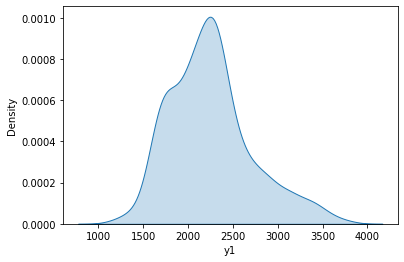

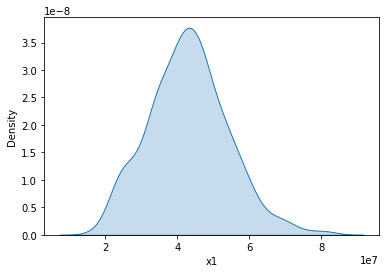

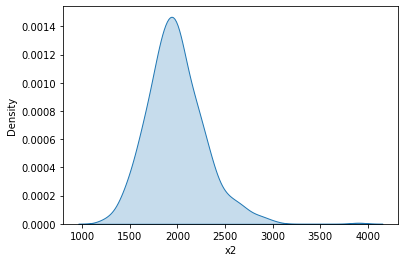

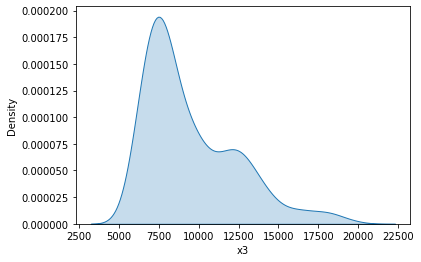

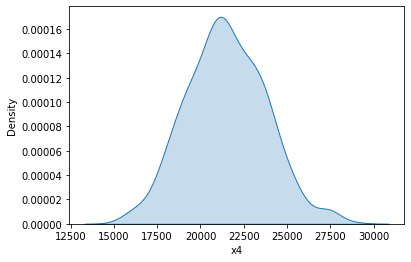

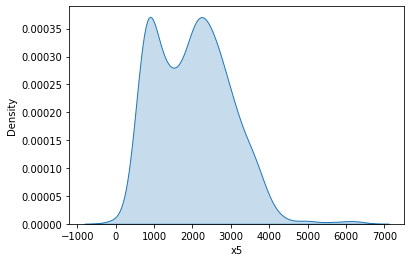

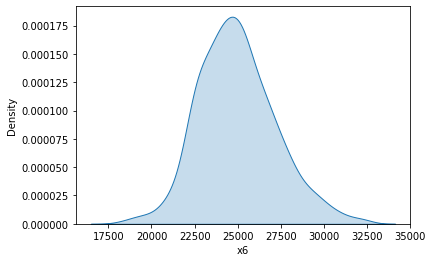

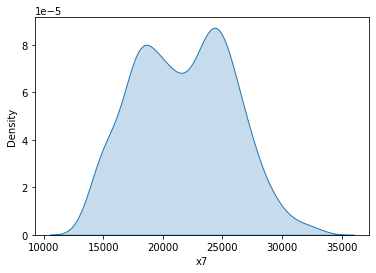

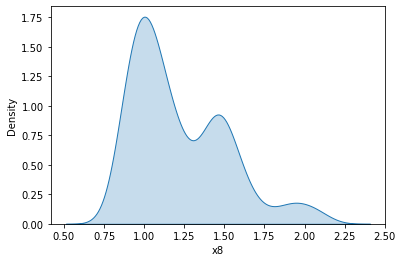

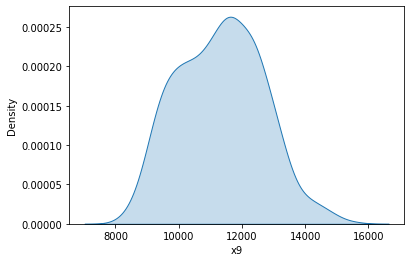

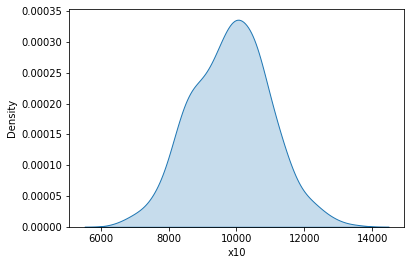

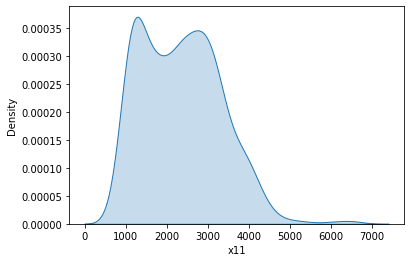

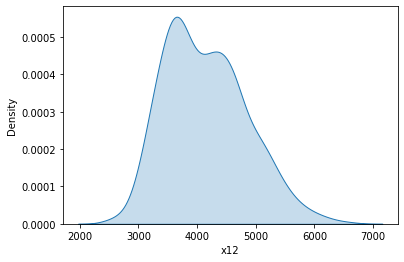

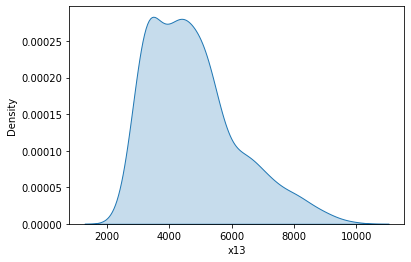

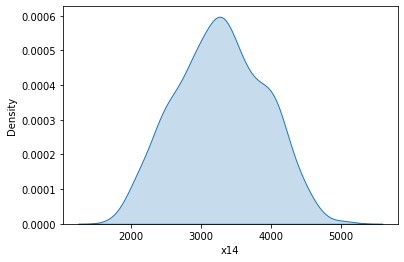

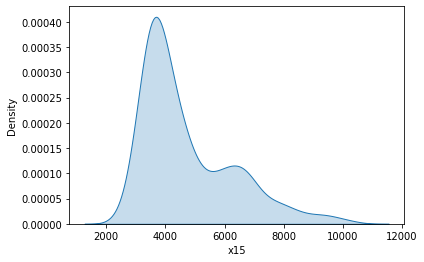

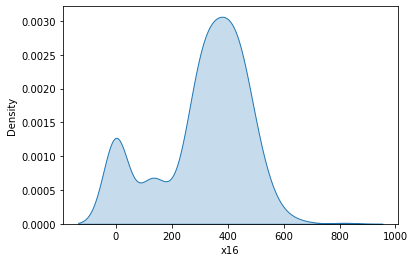

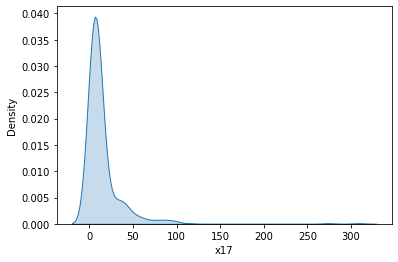

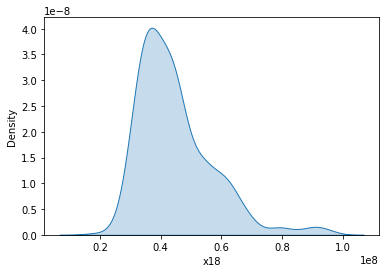

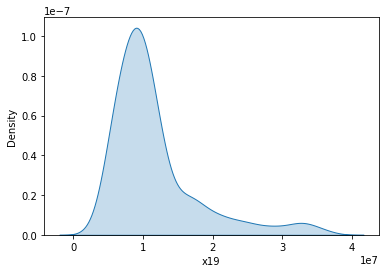

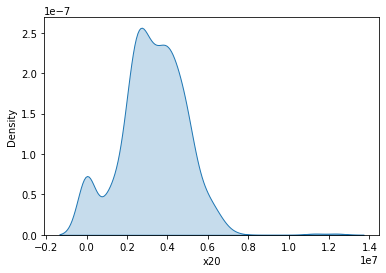

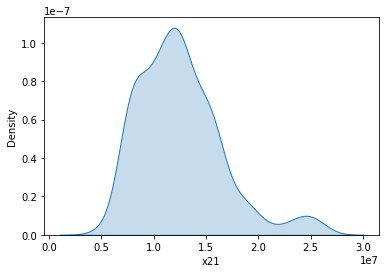

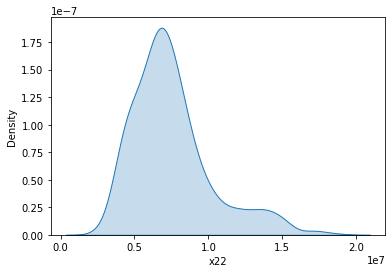

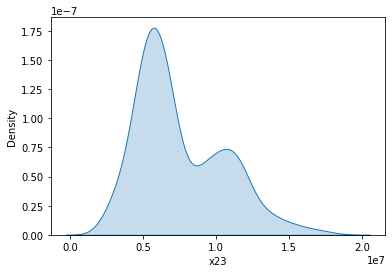

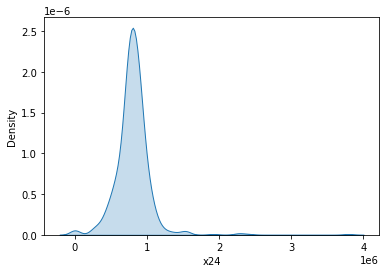

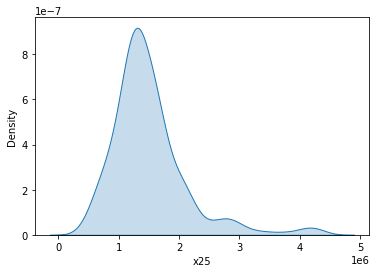

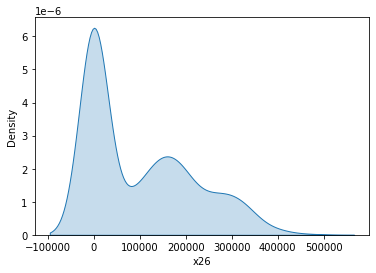

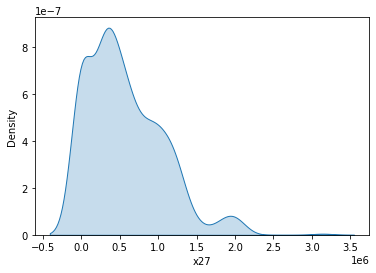

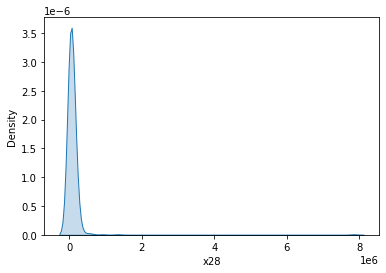

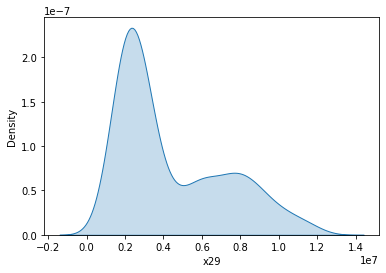

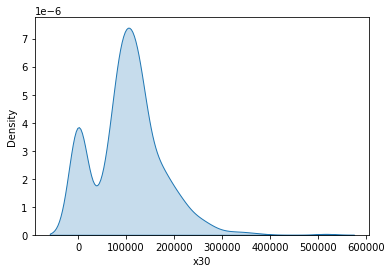

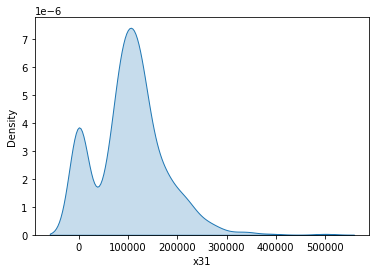

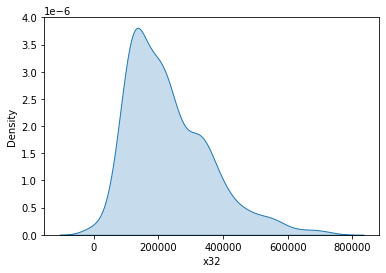

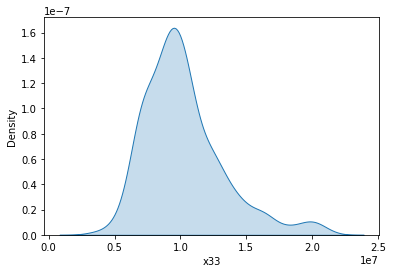

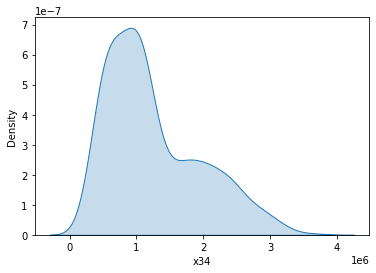

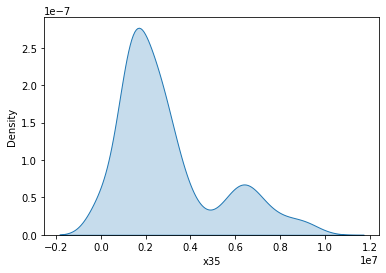

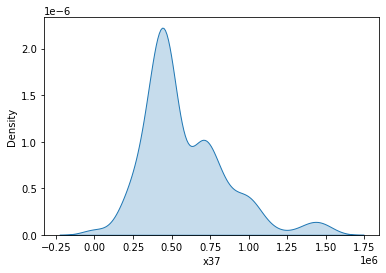

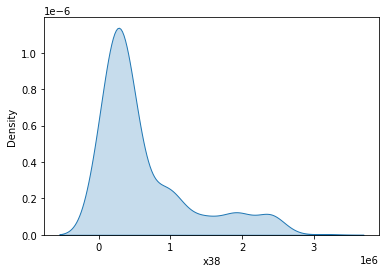

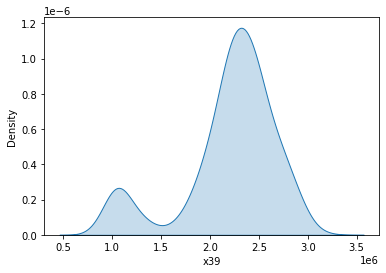

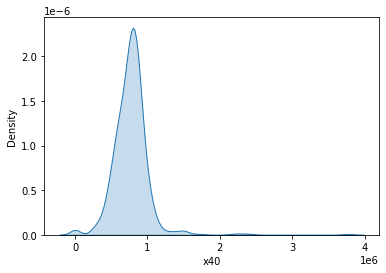

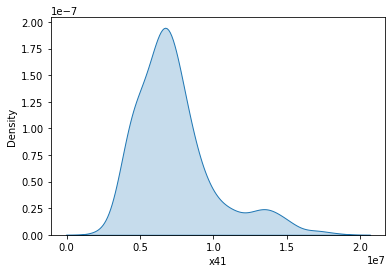

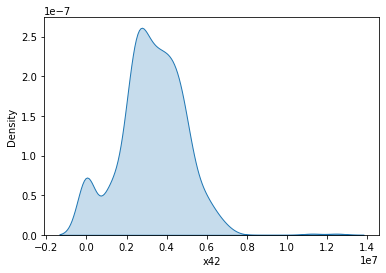

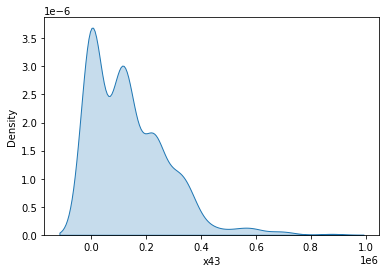

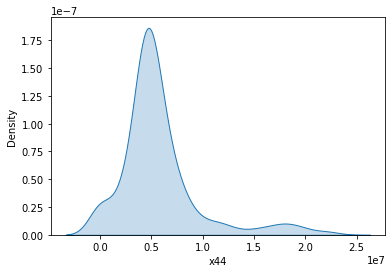

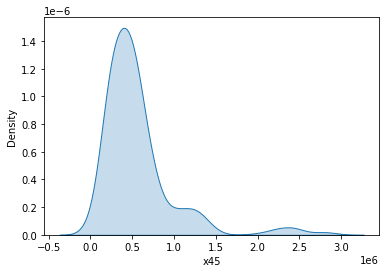

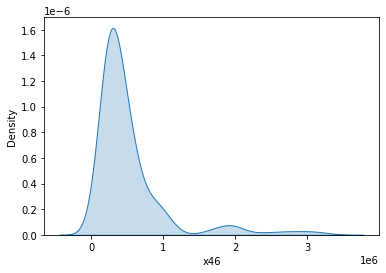

In [ ]:
for i in range(2,len(df.columns)):
  plt.figure()
  sns.kdeplot(df[df.columns[i]], label = df.columns[i], shade = True)

# Feature Transformation

In [ ]:
cols_to_keep = df[['date','y1']]
cols_to_keep.head()

,date,y1
0,2017-09-04 00:00:00+00:00,2258
1,2017-09-05 00:00:00+00:00,3140
2,2017-09-08 00:00:00+00:00,2253
3,2017-09-09 00:00:00+00:00,1888
4,2017-09-10 00:00:00+00:00,1623


In [ ]:
X = df
X.drop(columns = ['date','geo','y1'], inplace = True)
X.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42',
       'x43', 'x44', 'x45', 'x46'],
      dtype='object')

In [ ]:
#@title Input transformation type (ex: log, sqrt)
transformation = 'Square Root' #@param ["Square Root", "Mean","Log","Natural Log","None"]

In [ ]:
# These transformations stabilize large values in the dataset, and allow the data to be more normal
if transformation == "Square Root":
  X_transform = X.apply(np.sqrt)
elif transformation == "Mean":
  X_transform = X/X.mean()
elif transformation == "Natural Log": 
  X += 1 # natural log function is not defined at 0 so need to add 1 to each value 
  X_transform = X.apply(np.log)
else:
  X_transform = X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

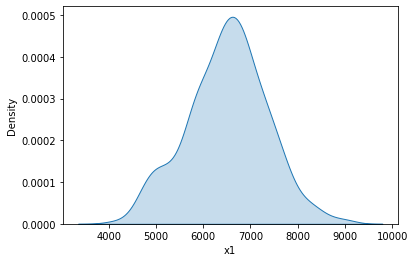

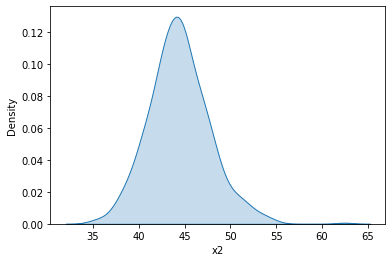

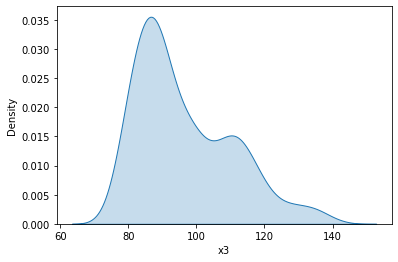

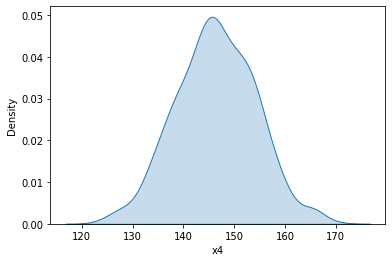

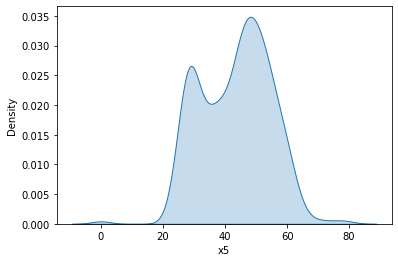

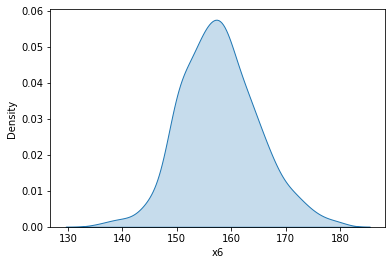

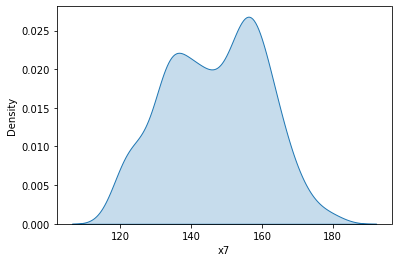

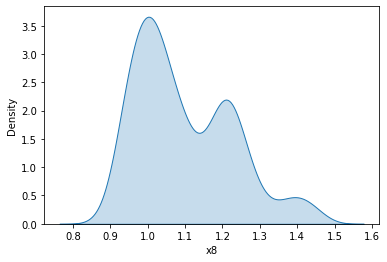

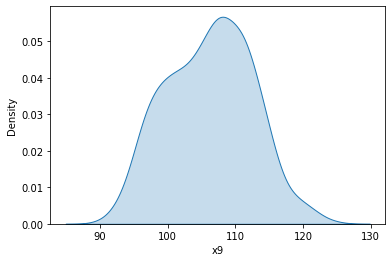

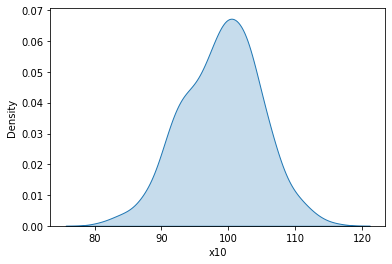

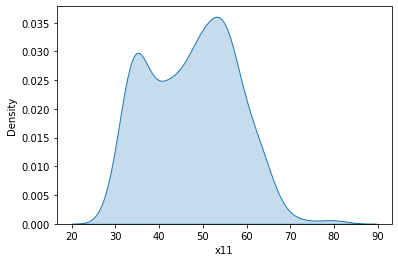

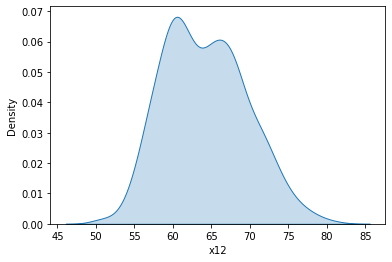

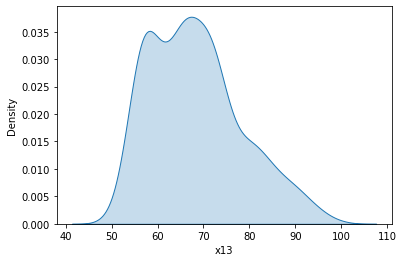

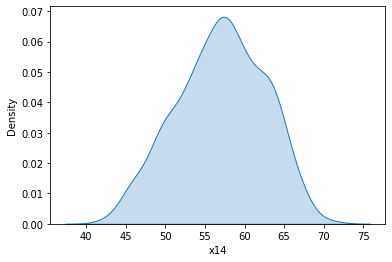

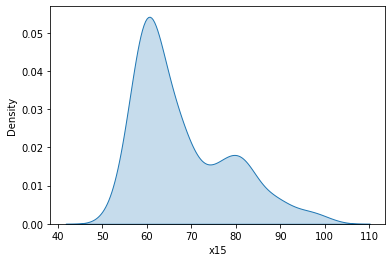

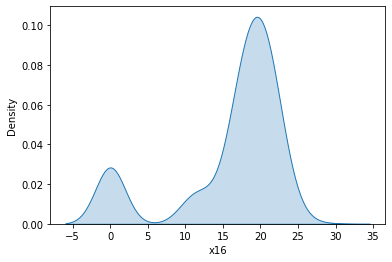

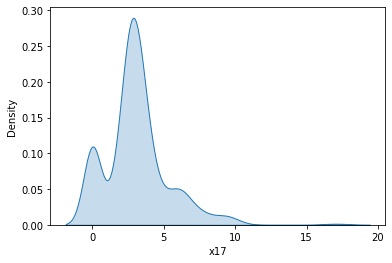

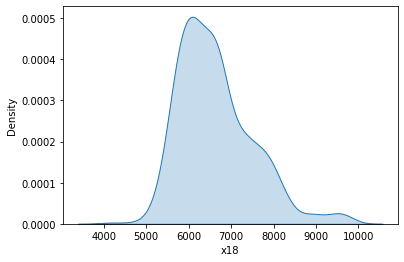

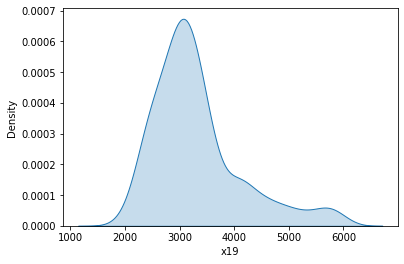

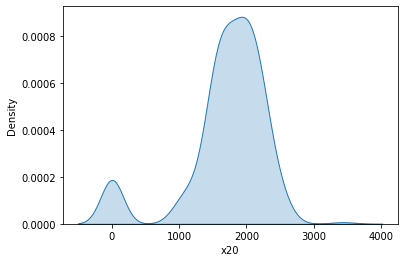

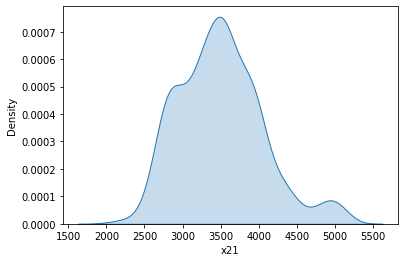

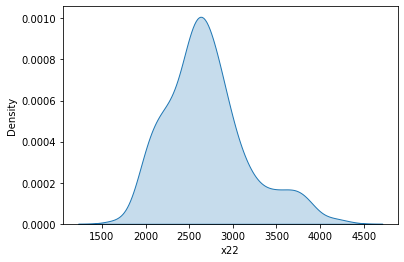

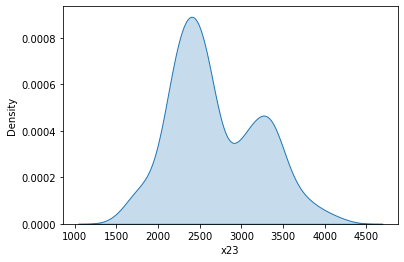

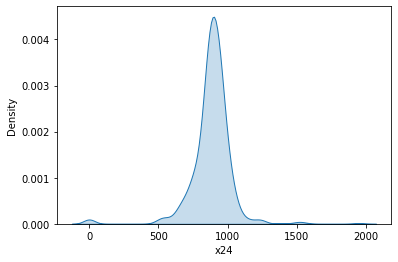

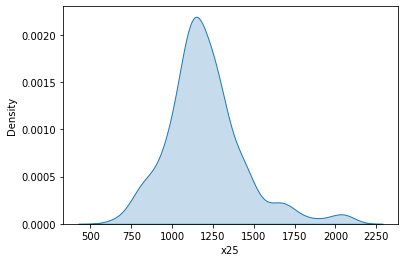

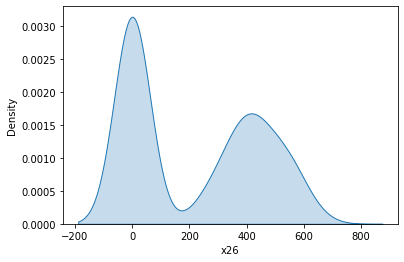

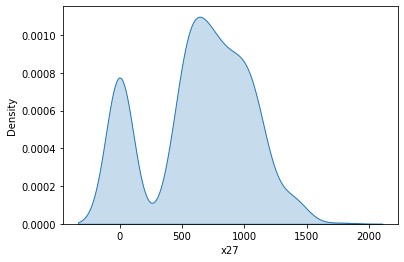

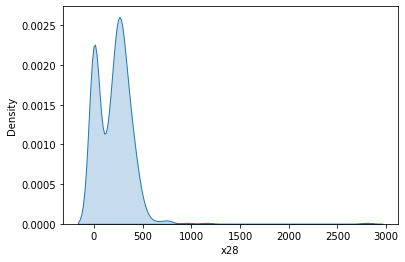

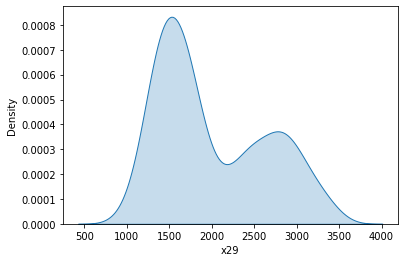

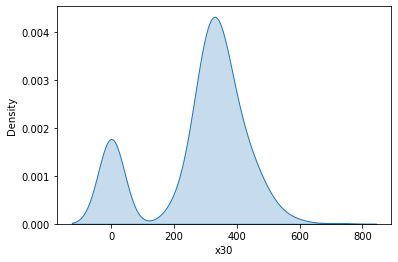

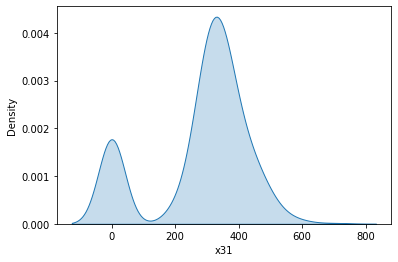

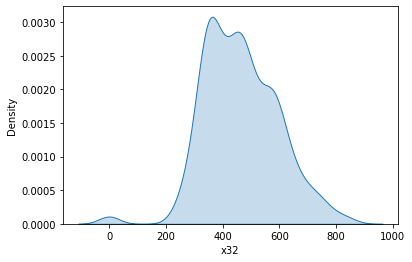

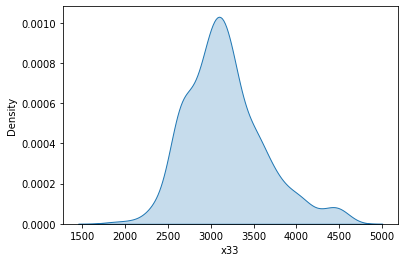

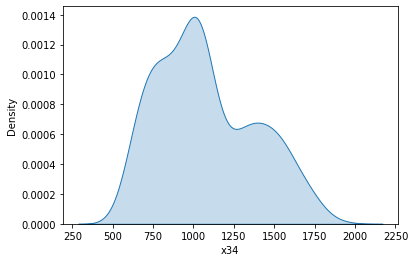

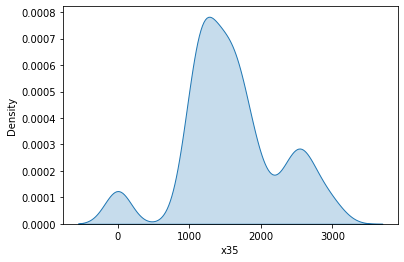

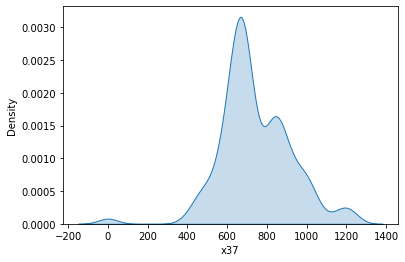

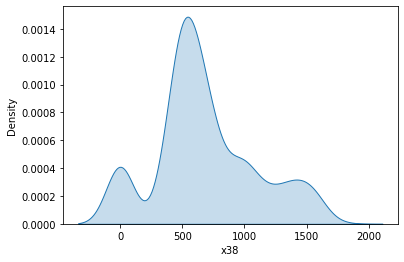

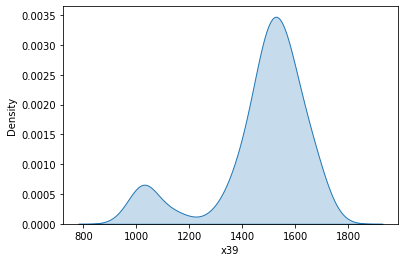

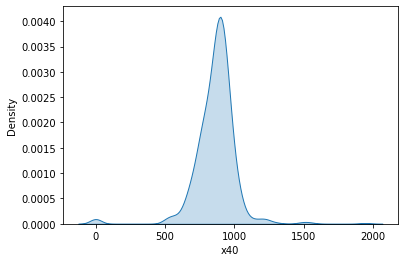

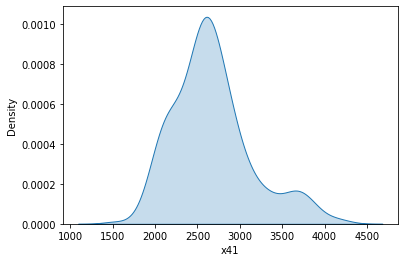

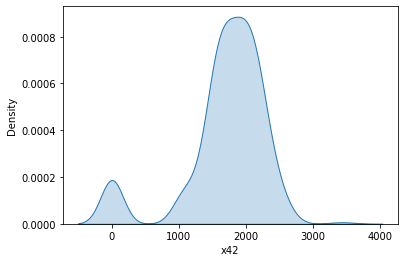

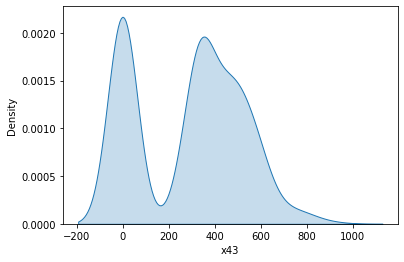

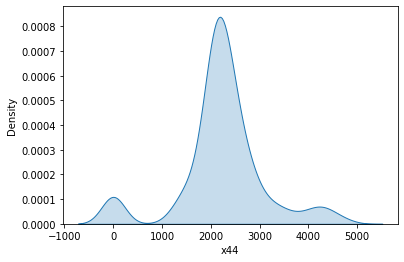

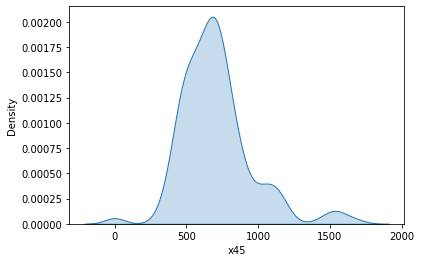

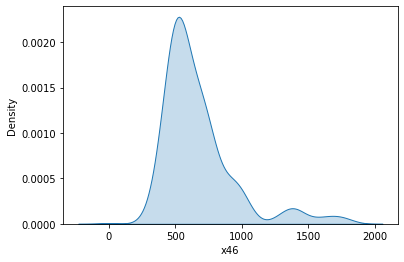

In [ ]:
for i in range(0,len(X_transform.columns)):
  plt.figure()
  sns.kdeplot(X_transform[X_transform.columns[i]], label = X_transform.columns[i], shade = True)

# Feature Scaling

In [ ]:
standardize_features = "Yes" #@param {type: "string"}

In [ ]:
if standardize_features == "No":
  X_transform_stand = X_transform
elif standardize_features == "Yes":
  #scaler = StandardScaler()
  scaler = MinMaxScaler()
  #standardized_transform = scaler.fit_transform(X_transform)
  standardized_transform = MinMaxScaler().fit_transform(X_transform)
  X_transform_stand = pd.DataFrame(standardized_transform, columns = X.columns)
else:
  X_transform_stand = X_transform

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

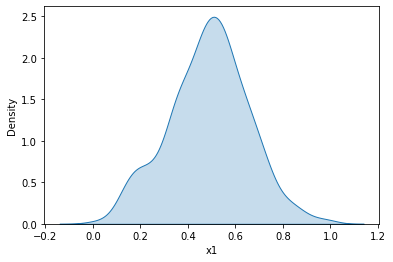

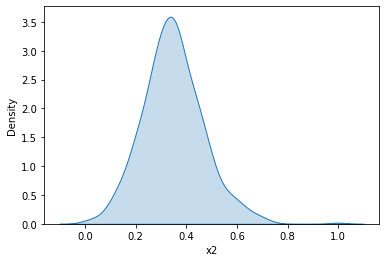

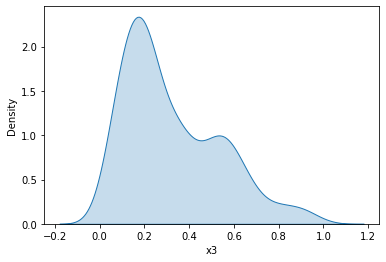

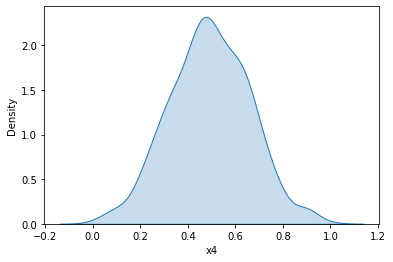

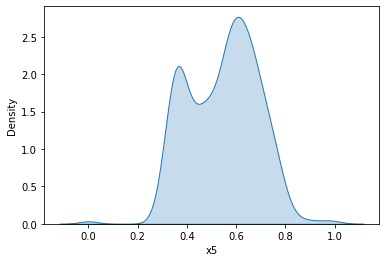

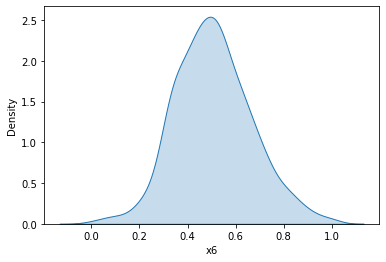

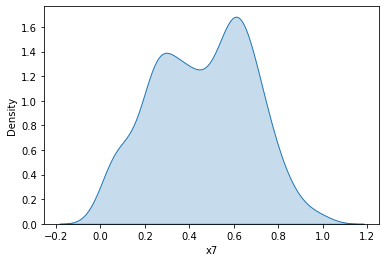

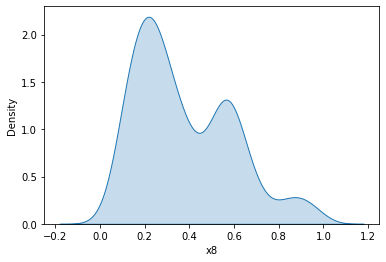

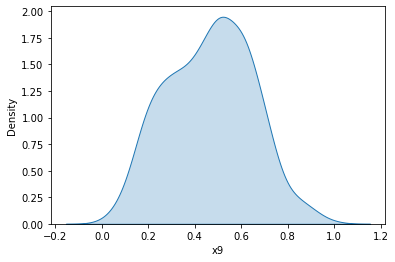

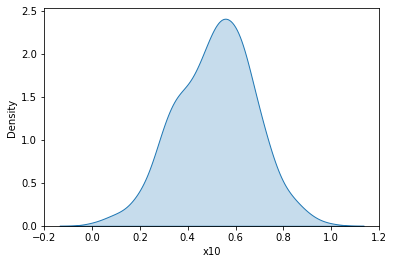

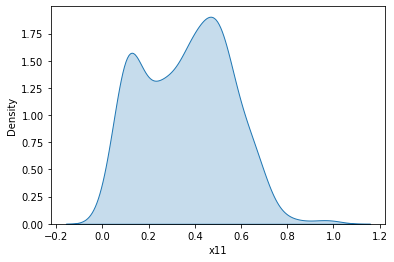

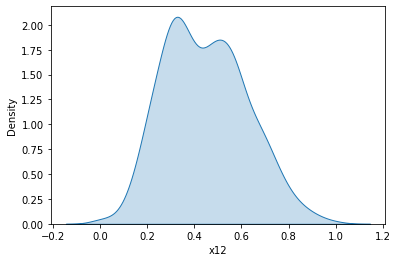

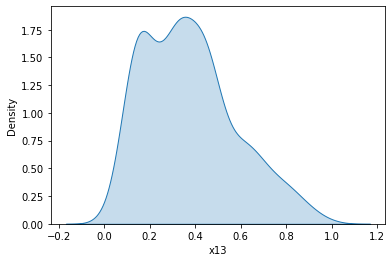

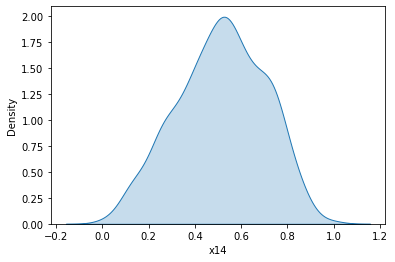

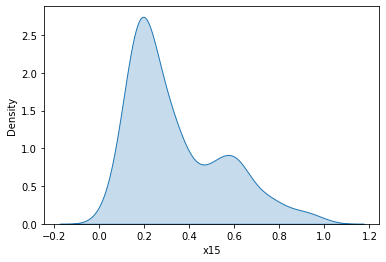

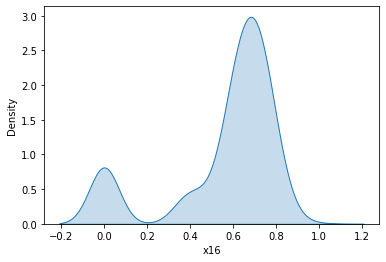

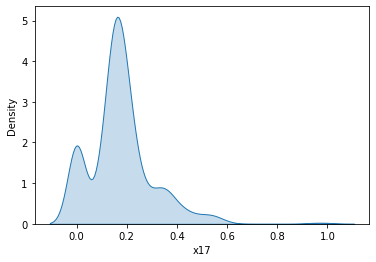

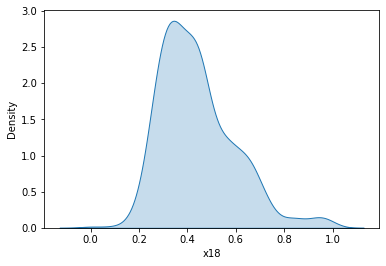

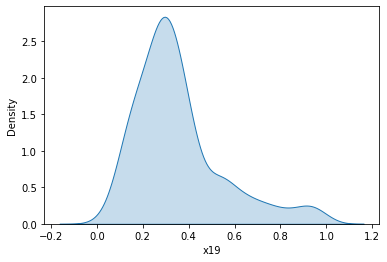

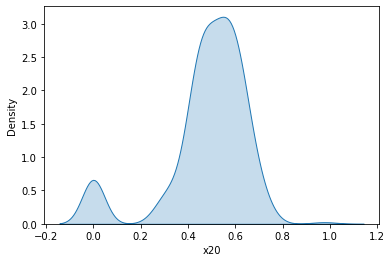

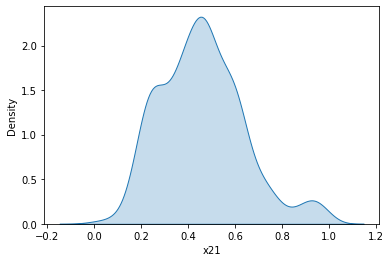

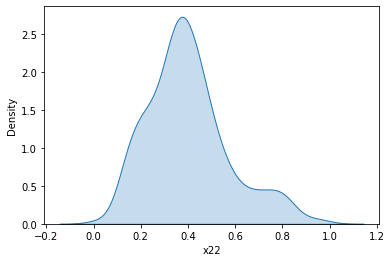

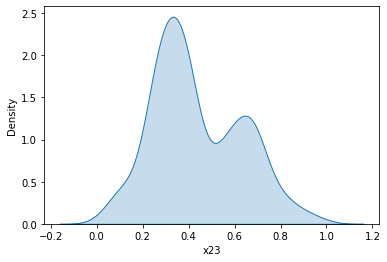

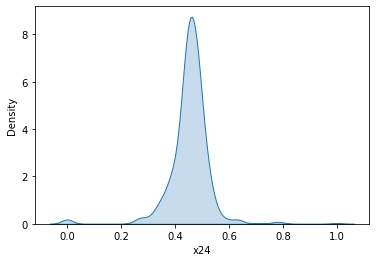

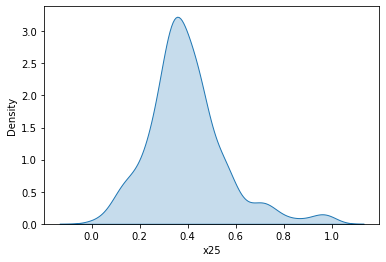

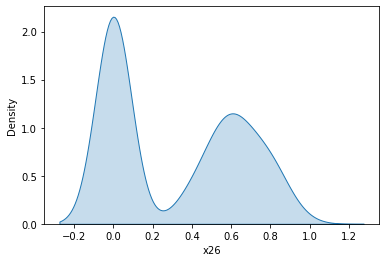

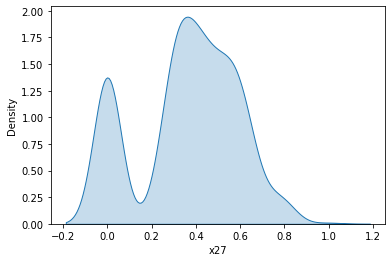

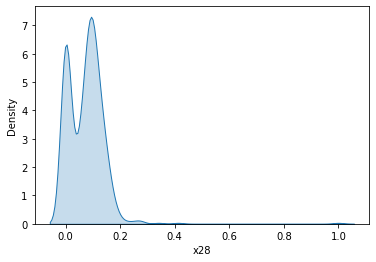

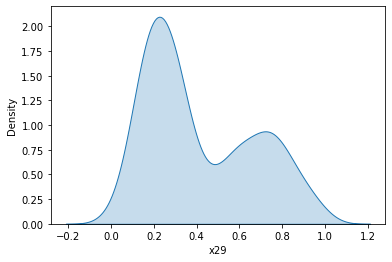

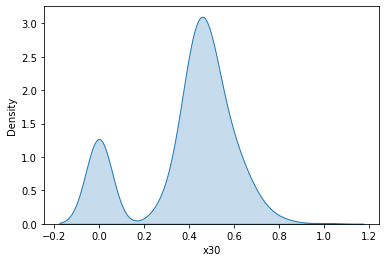

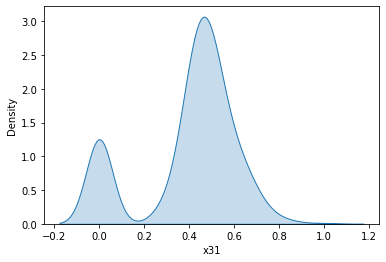

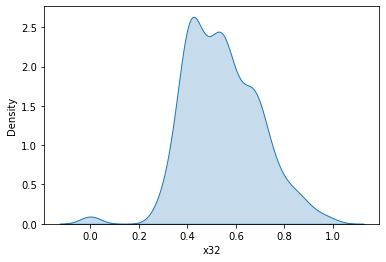

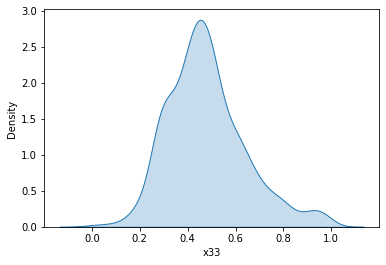

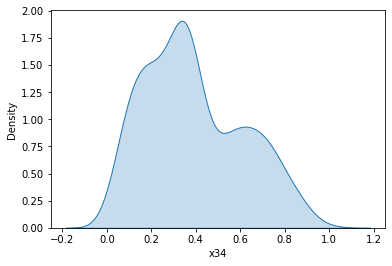

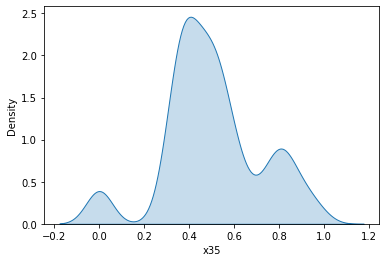

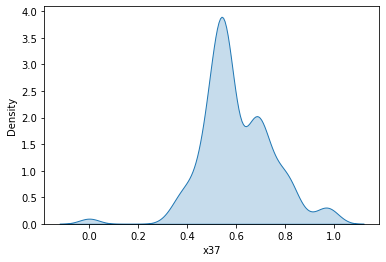

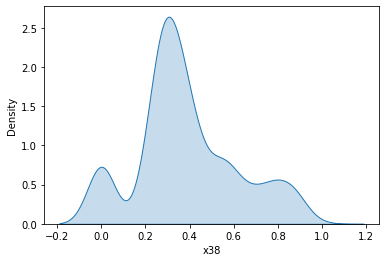

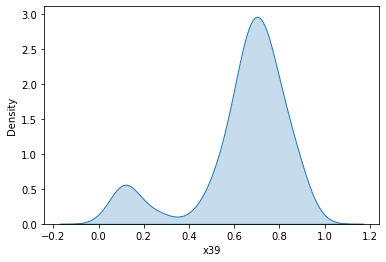

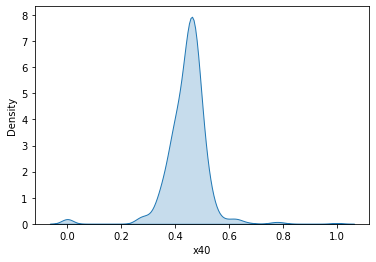

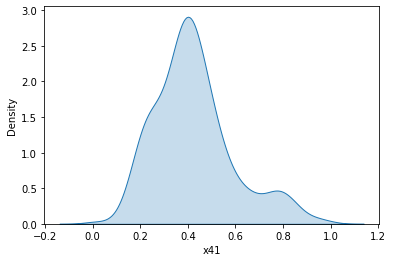

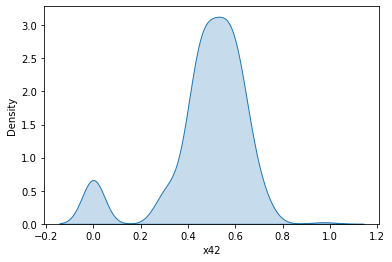

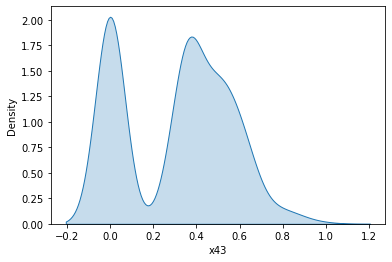

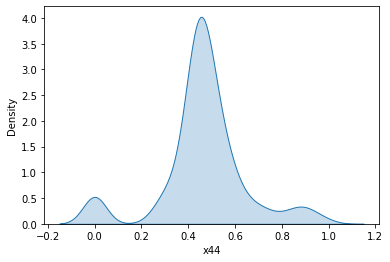

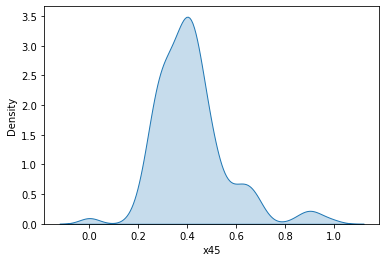

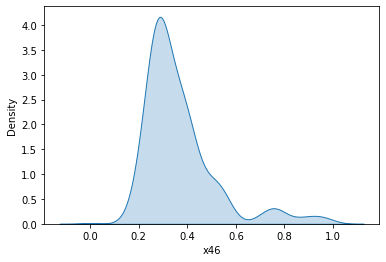

In [ ]:
for i in range(0,len(X_transform_stand.columns)):
  plt.figure()
  sns.kdeplot(X_transform_stand[X_transform_stand.columns[i]], label = X_transform_stand.columns[i], shade = True)

In [ ]:
# Add back in date and KPI features

In [ ]:
X_transform_stand['y1'] = cols_to_keep['y1']
X_transform_stand['date'] = cols_to_keep['date']
df = X_transform_stand
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,y1,date
0,0.57504,0.27060,0.71556,0.48402,0.68227,0.71226,0.54153,0.37630,0.48899,0.50590,0.54532,0.21536,0.76299,0.15683,0.66742,0.72711,0.37304,0.44034,0.12308,0.57047,0.64929,0.45295,0.37763,0.40068,0.72303,0.87324,0.33834,0.00000,0.24737,0.46451,0.46876,0.87389,0.68452,0.37422,0.35818,0.54948,0.77426,0.71201,0.41235,0.46916,0.56303,0.00000,0.27209,0.91278,0.71936,2258,2017-09-04 00:00:00+00:00
1,0.55447,0.36515,1.00000,0.83469,0.74784,0.99180,0.99463,0.17316,0.74159,0.92437,0.66785,0.32645,0.93419,0.27374,0.99199,0.75835,0.36868,0.48556,0.19039,0.55072,0.62613,0.53498,0.37142,0.41952,0.90612,0.89422,0.54359,0.00000,0.18829,0.47058,0.48178,0.96884,0.68462,0.34698,0.33894,0.55103,0.75708,0.72979,0.39465,0.59907,0.54563,0.00000,0.31188,0.98093,0.87675,3140,2017-09-05 00:00:00+00:00
2,0.64000,0.30568,0.88438,0.60766,0.66734,0.77194,0.80153,0.20177,0.51542,0.68342,0.53818,0.23135,0.78239,0.22268,0.93187,0.71697,0.52139,0.37720,0.14652,0.48920,0.34666,0.54303,0.37498,0.44727,0.69825,0.87164,0.52402,0.00000,0.22282,0.47359,0.46275,0.76018,0.32578,0.41015,0.34844,0.46398,0.68175,0.68754,0.39290,0.52016,0.46265,0.00000,0.29406,0.87586,0.75203,2253,2017-09-08 00:00:00+00:00
3,0.62049,0.27530,0.74163,0.46213,0.70029,0.69711,0.60166,0.34723,0.50216,0.43793,0.55027,0.13419,0.73284,0.12042,0.72704,0.71782,0.50242,0.31317,0.10413,0.45849,0.30539,0.42497,0.35651,0.40676,0.64935,0.81122,0.50405,0.00000,0.15231,0.48786,0.46565,0.74356,0.33026,0.43076,0.39147,0.45872,0.76627,0.19630,0.36003,0.44203,0.43723,0.00000,0.31029,0.89146,0.73121,1888,2017-09-09 00:00:00+00:00
4,0.62111,0.37438,0.92744,0.70085,0.68332,0.91132,0.79552,0.31174,0.79951,0.56154,0.57790,0.19228,1.00000,0.13873,0.81414,0.72711,0.53366,0.36880,0.14844,0.47562,0.39746,0.43874,0.38428,0.39573,0.67283,0.92894,0.48125,0.00000,0.20061,0.47797,0.47453,0.71401,0.39482,0.36319,0.39172,0.44526,0.79924,0.76372,0.38380,0.45698,0.47765,0.00000,0.29382,0.91105,0.72985,1623,2017-09-10 00:00:00+00:00


#Feature Selection

Note: A **max of 50 features** is recommended for 24 months of data due to risk of overfitting. 

1. **Step 1**: run correlation analysis & output pos/neg coefficients above specified threshold

2. **Step 2**: run variance inflation factor analysis & output results to flag multicollinearity above specified threshold 

3. checkpoint to update the INITIAL design of features if multicollinearity is an issue

4. **Step 3**: perform multivariate testing to FINALIZE feature selection / data reduction (see optional section below for advanced feature selection if you have more than 50 inputs)
 


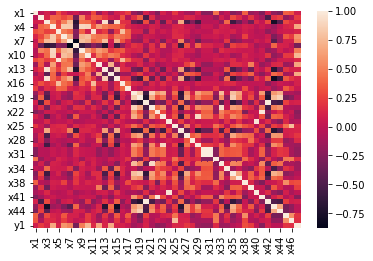

In [ ]:
sns.heatmap(df.corr())

## Step 1: Run correlation analysis & filter to positive coefficients > the specified threshold

In [ ]:
#@title Input correlation threshold for output (must be between 0 and 1)

THRESHOLD_1 =  .6 #@param {type: "number"}

In [ ]:
correl = df.corr()
correl

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,y1
x1,1.00000,0.00210,0.09410,-0.03838,0.30202,0.13085,0.01579,0.07030,-0.04701,-0.01662,0.27911,-0.14347,0.09419,-0.11243,0.09193,0.13935,0.23951,-0.16469,-0.28466,0.10063,-0.04943,-0.25817,0.10811,-0.01602,0.21272,0.02788,-0.08004,-0.14358,0.09904,-0.23642,-0.23413,0.43713,-0.09558,0.01598,-0.24705,-0.16892,0.37481,-0.17322,-0.09743,-0.26842,0.10222,-0.20001,-0.27739,0.36856,0.33055,0.08451
x2,0.00210,1.00000,0.13148,0.38451,0.37159,0.27408,0.37801,-0.34857,0.51054,0.15367,0.36846,0.33525,0.20858,0.09567,0.04535,0.31706,-0.04887,0.17523,0.36661,-0.49957,0.16152,-0.12747,-0.01397,0.00951,0.06334,0.05335,0.15360,0.13413,0.02743,-0.02401,-0.02216,-0.16828,0.09448,-0.03923,0.28305,0.15973,-0.01531,0.20350,0.00573,-0.12229,-0.50391,0.18120,0.24857,-0.18559,-0.06643,0.22975
x3,0.09410,0.13148,1.00000,0.45387,0.24485,0.50822,0.76131,-0.66248,0.43318,0.41050,0.23463,-0.06934,0.95126,-0.42259,0.95704,0.18597,0.16534,-0.39150,-0.50308,0.29235,-0.31670,0.06873,-0.38894,0.13775,-0.13774,0.68252,-0.51836,-0.25357,-0.55162,-0.03289,-0.03436,-0.00456,-0.17832,0.41029,-0.57865,-0.34887,-0.08597,-0.33035,0.14256,0.02514,0.28432,-0.76868,-0.45023,0.28474,0.16427,0.13228
x4,-0.03838,0.38451,0.45387,1.00000,0.27902,0.83583,0.82796,-0.57870,0.90227,0.87907,0.32483,0.62921,0.47940,0.39694,0.38709,0.28805,0.13179,0.06308,0.03231,-0.01410,0.10848,0.07148,-0.04925,-0.01996,0.12199,0.13448,0.05136,0.02135,-0.09681,0.05280,0.05305,-0.05129,0.10783,0.08677,0.00946,0.02591,0.10069,0.07213,-0.00907,0.06369,-0.01937,-0.15125,0.01880,0.12067,0.15546,0.67936
x5,0.30202,0.37159,0.24485,0.27902,1.00000,0.47521,0.38225,-0.22693,0.38321,0.11151,0.97375,0.13931,0.23036,-0.18887,0.22383,0.78158,0.38170,0.11184,0.10559,-0.20076,0.13484,-0.00663,0.07455,0.01490,0.14945,0.11386,0.08567,-0.03411,0.01361,0.00070,0.00325,0.12975,0.08702,0.07446,0.11289,0.00466,0.08386,0.03515,-0.04008,-0.00430,-0.20020,-0.08339,0.05517,0.08476,0.07820,0.12451
x6,0.13085,0.27408,0.50822,0.83583,0.47521,1.00000,0.67203,-0.28238,0.72485,0.78573,0.51295,0.44573,0.47436,0.24403,0.48961,0.42164,0.36721,-0.03887,-0.11838,0.07553,0.04309,-0.00619,-0.03871,0.00943,0.15977,0.15482,0.03337,-0.07086,-0.11971,0.04602,0.04497,0.07082,0.01596,0.07665,-0.10083,-0.04062,0.25215,0.03047,-0.00963,-0.01497,0.07183,-0.27350,-0.12001,0.33570,0.23525,0.59440
x7,0.01579,0.37801,0.76131,0.82796,0.38225,0.67203,1.00000,-0.87802,0.79275,0.70900,0.39782,0.46111,0.77829,0.07131,0.68670,0.33107,0.12538,-0.17121,-0.19031,0.12467,-0.13237,0.04537,-0.28365,0.06984,-0.04404,0.51293,-0.22825,-0.01132,-0.35965,-0.08177,-0.08133,-0.00299,-0.05955,0.22011,-0.27090,-0.18270,-0.03259,-0.04280,0.08213,0.01836,0.11680,-0.44587,-0.15108,0.10384,0.10730,0.51844
x8,0.07030,-0.34857,-0.66248,-0.57870,-0.22693,-0.28238,-0.87802,1.00000,-0.60910,-0.43989,-0.22386,-0.35529,-0.71169,0.03198,-0.57373,-0.19203,0.06516,0.19316,0.15318,-0.07546,0.18751,-0.05152,0.34337,-0.07567,0.15034,-0.56669,0.30615,-0.03344,0.38607,0.13904,0.13689,0.06263,0.08105,-0.23709,0.26338,0.19116,0.20807,0.07054,-0.10783,-0.02386,-0.06852,0.39751,0.11538,0.10227,0.01367,-0.31700
x9,-0.04701,0.51054,0.43318,0.90227,0.38321,0.72485,0.79275,-0.60910,1.00000,0.61254,0.42024,0.61983,0.52563,0.21398,0.31006,0.35037,0.14393,0.11462,0.14150,-0.17767,0.17133,0.06318,-0.04946,-0.04539,0.07732,0.13765,0.07115,0.07990,-0.09189,0.04668,0.04731,-0.13240,0.17281,0.10892,0.08670,0.05706,0.04224,0.05581,-0.02834,0.05942,-0.18075,-0.11371,0.09732,0.00125,0.06776,0.48722
x10,-0.01662,0.15367,0.41050,0.87907,0.11151,0.78573,0.70900,-0.43989,0.61254,1.00000,0.15641,0.50334,0.35330,0.49348,0.42129,0.16444,0.10201,-0.04525,-0.13542,0.20227,-0.01641,0.05528,-0.06957,0.00612,0.12455,0.13887,-0.01337,-0.04853,-0.11596,0.03135,0.03024,0.06026,-0.01342,0.04807,-0.12055,-0.05092,0.13089,0.05243,0.01134,0.04430,0.19673,-

In [ ]:
# output correlations > threshold_1 to review for data reduction

corrs_pos = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_pos = corrs_pos[corrs_pos > THRESHOLD_1].stack().reset_index() # user defines threshold and can increase to be more conservative
corrs_pos = corrs_pos.loc[corrs_pos[0]<1.0]
corrs_pos

,level_0,level_1,0
3,x3,x7,0.76131
4,x3,x13,0.95126
5,x3,x15,0.95704
6,x3,x26,0.68252
8,x4,x6,0.83583
9,x4,x7,0.82796
10,x4,x9,0.90227
11,x4,x10,0.87907
12,x4,x12,0.62921
13,x4,y1,0.67936


In [ ]:
corrs_pos.level_0.value_counts()

x18    10
x4     6 
x19    5 
x3     4 
x7     4 
x35    3 
x6     3 
x12    2 
x9     2 
x5     2 
x27    2 
x13    2 
x21    2 
x43    1 
x30    1 
x15    1 
x11    1 
x24    1 
x14    1 
x20    1 
x23    1 
x25    1 
x10    1 
x22    1 
Name: level_0, dtype: int64

In [ ]:
corrs_pos.level_1.value_counts()

x43    4
y1     4
x10    4
x35    4
x44    4
x9     3
x26    3
x15    3
x7     3
x41    2
x21    2
x13    2
x12    2
x37    2
x33    2
x29    2
x16    2
x40    1
x42    1
x46    1
x23    1
x11    1
x14    1
x27    1
x31    1
x19    1
x6     1
Name: level_1, dtype: int64

In [ ]:
#@title Input 2nd correlation threshold (must be between -1 and 0)
THRESHOLD_2 =  -.6 #@param {type: "number"}

In [ ]:
# feature reduction 1B: output correlations < threshold_2 to review for data reduction 
corrs_neg = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_neg = corrs_neg[corrs_neg < THRESHOLD_2].stack().reset_index() # user defines threshold and can decrease to be more conservative
corrs_neg = corrs_neg.loc[corrs_neg[0]<1.0]
corrs_neg

,level_0,level_1,0
0,x3,x8,-0.66248
1,x3,x43,-0.76868
2,x7,x8,-0.87802
3,x8,x9,-0.60910
4,x8,x13,-0.71169
5,x13,x43,-0.67930
6,x15,x35,-0.60462
7,x15,x43,-0.80357
8,x18,x26,-0.63836
9,x19,x20,-0.70964


In [ ]:
corrs_neg.level_0.value_counts()

x15    2
x3     2
x8     2
x26    2
x19    2
x18    1
x21    1
x20    1
x13    1
x7     1
x35    1
Name: level_0, dtype: int64

In [ ]:
corrs_neg.level_1.value_counts()

x43    4
x42    2
x26    2
x8     2
x35    2
x29    1
x20    1
x13    1
x9     1
Name: level_1, dtype: int64

In [ ]:
#drop highly correlated columns
df.drop(columns = ['x18','x4'], inplace = True)

## Step 2: Check for Multicollinearity


Run variance inflation factor (VIF) analysis & review values > 7 

Notes: 
*   Industry best practice flags values > 10 as a violation of regression model assumptions

In [ ]:
df.head()

,x1,x2,x3,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,y1,date
0,0.57504,0.27060,0.71556,0.68227,0.71226,0.54153,0.37630,0.48899,0.50590,0.54532,0.21536,0.76299,0.15683,0.66742,0.72711,0.37304,0.12308,0.57047,0.64929,0.45295,0.37763,0.40068,0.72303,0.87324,0.33834,0.00000,0.24737,0.46451,0.46876,0.87389,0.68452,0.37422,0.35818,0.54948,0.77426,0.71201,0.41235,0.46916,0.56303,0.00000,0.27209,0.91278,0.71936,2258,2017-09-04 00:00:00+00:00
1,0.55447,0.36515,1.00000,0.74784,0.99180,0.99463,0.17316,0.74159,0.92437,0.66785,0.32645,0.93419,0.27374,0.99199,0.75835,0.36868,0.19039,0.55072,0.62613,0.53498,0.37142,0.41952,0.90612,0.89422,0.54359,0.00000,0.18829,0.47058,0.48178,0.96884,0.68462,0.34698,0.33894,0.55103,0.75708,0.72979,0.39465,0.59907,0.54563,0.00000,0.31188,0.98093,0.87675,3140,2017-09-05 00:00:00+00:00
2,0.64000,0.30568,0.88438,0.66734,0.77194,0.80153,0.20177,0.51542,0.68342,0.53818,0.23135,0.78239,0.22268,0.93187,0.71697,0.52139,0.14652,0.48920,0.34666,0.54303,0.37498,0.44727,0.69825,0.87164,0.52402,0.00000,0.22282,0.47359,0.46275,0.76018,0.32578,0.41015,0.34844,0.46398,0.68175,0.68754,0.39290,0.52016,0.46265,0.00000,0.29406,0.87586,0.75203,2253,2017-09-08 00:00:00+00:00
3,0.62049,0.27530,0.74163,0.70029,0.69711,0.60166,0.34723,0.50216,0.43793,0.55027,0.13419,0.73284,0.12042,0.72704,0.71782,0.50242,0.10413,0.45849,0.30539,0.42497,0.35651,0.40676,0.64935,0.81122,0.50405,0.00000,0.15231,0.48786,0.46565,0.74356,0.33026,0.43076,0.39147,0.45872,0.76627,0.19630,0.36003,0.44203,0.43723,0.00000,0.31029,0.89146,0.73121,1888,2017-09-09 00:00:00+00:00
4,0.62111,0.37438,0.92744,0.68332,0.91132,0.79552,0.31174,0.79951,0.56154,0.57790,0.19228,1.00000,0.13873,0.81414,0.72711,0.53366,0.14844,0.47562,0.39746,0.43874,0.38428,0.39573,0.67283,0.92894,0.48125,0.00000,0.20061,0.47797,0.47453,0.71401,0.39482,0.36319,0.39172,0.44526,0.79924,0.76372,0.38380,0.45698,0.47765,0.00000,0.29382,0.91105,0.72985,1623,2017-09-10 00:00:00+00:00


In [ ]:
vif = add_constant(df.drop(columns=[DATE_COL, KPI_COL]))

# loop to calculate the VIF for each X 
vif = pd.Series([variance_inflation_factor(vif.values, i) 
      for i in range(vif.shape[1])], 
      index=vif.columns) 
print(vif.sort_values(ascending=False))

const   713.65160
x30     225.92403
x31     224.25214
x20     135.01139
x42     132.32801
x3      72.07599 
x7      58.73874 
x15     41.94068 
x41     41.11809 
x22     40.67749 
x13     34.59112 
x23     30.23196 
x6      28.48577 
x40     26.82461 
x11     26.41133 
x24     25.91619 
x5      25.48111 
x29     25.01882 
x21     23.38663 
x25     21.56645 
x8      21.39746 
x19     20.56780 
x10     19.78715 
x14     17.64841 
x9      16.45695 
x46     14.75105 
x33     14.10121 
x12     10.83735 
x43     9.81955  
x44     9.60107  
x35     7.68403  
x37     6.98302  
x26     6.45388  
x34     5.27206  
x27     4.74769  
x38     4.72551  
x45     4.31731  
x32     4.25243  
x39     3.68358  
x16     3.54761  
x2      2.91962  
x1      2.86741  
x17     1.88969  
x28     1.78040  
dtype: float64


In [ ]:
# processing to output VIF results as a dataframe 
vif_df=vif.to_frame().reset_index()

vif_df.columns = ['feature', 'vif']
vif_df=vif_df.replace([np.inf], np.nan) # replace inf calculations as missing and zero fill 
vif_df=vif_df.fillna(0).sort_values(by="vif", ascending=False)

In [ ]:
vif_df

,feature,vif
0,const,713.65160
28,x30,225.92403
29,x31,224.25214
18,x20,135.01139
39,x42,132.32801
3,x3,72.07599
6,x7,58.73874
14,x15,41.94068
38,x41,41.11809
20,x22,40.67749


In [ ]:
vif_df = vif_df[vif_df['feature']!='const']
vif_df[vif_df['vif'] >= 10].feature.tolist()

['x30',
 'x31',
 'x20',
 'x42',
 'x3',
 'x7',
 'x15',
 'x41',
 'x22',
 'x13',
 'x23',
 'x6',
 'x40',
 'x11',
 'x24',
 'x5',
 'x29',
 'x21',
 'x25',
 'x8',
 'x19',
 'x10',
 'x14',
 'x9',
 'x46',
 'x33',
 'x12']

In [ ]:
df = df.drop(columns = vif_df[vif_df['vif'] >= 10].feature.tolist())
df.columns

Index(['x1', 'x2', 'x16', 'x17', 'x26', 'x27', 'x28', 'x32', 'x34', 'x35',
       'x37', 'x38', 'x39', 'x43', 'x44', 'x45', 'y1', 'date'],
      dtype='object')

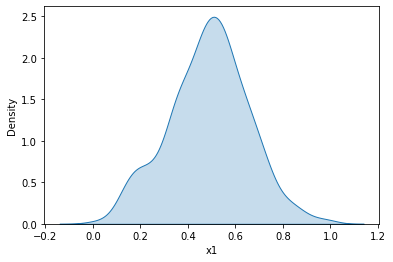

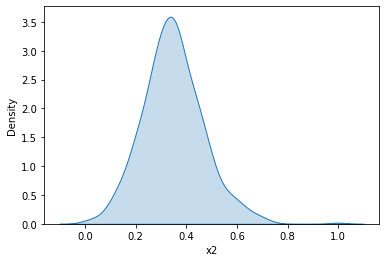

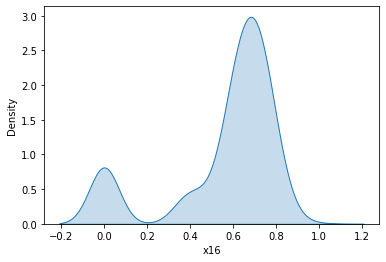

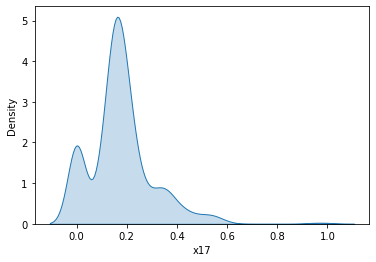

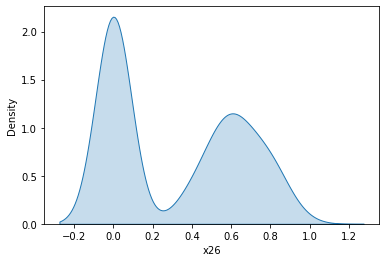

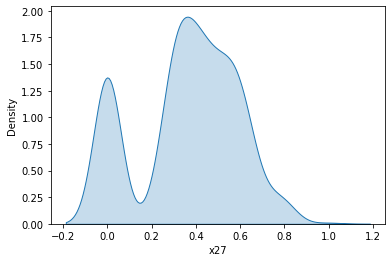

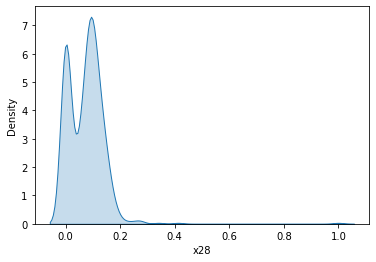

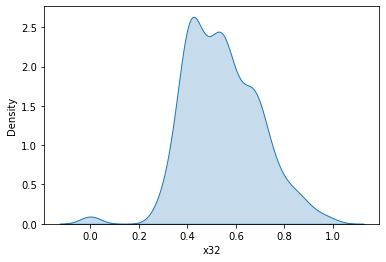

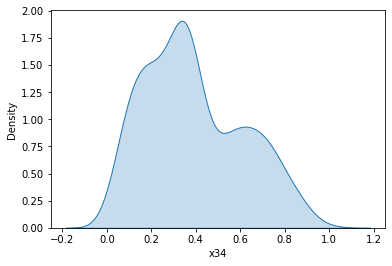

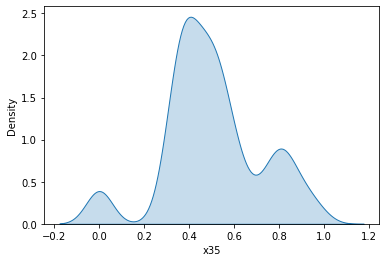

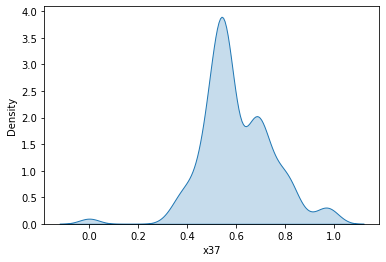

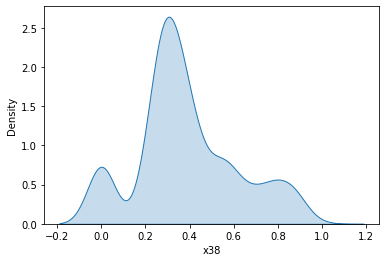

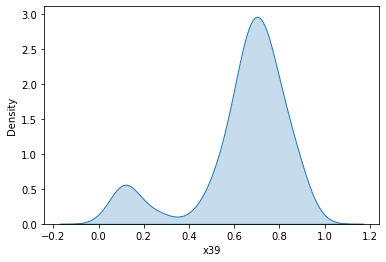

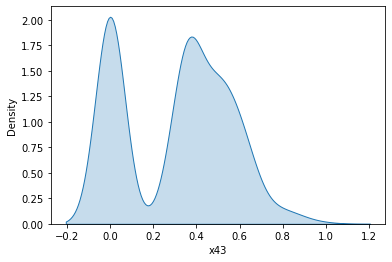

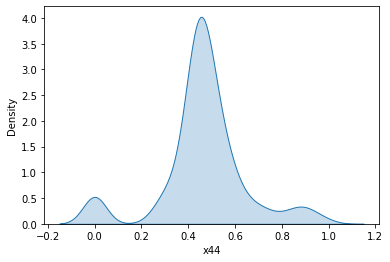

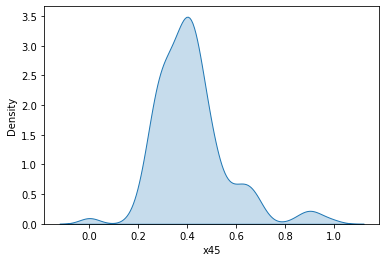

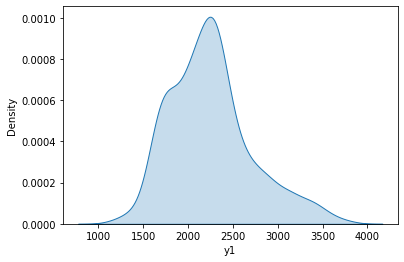

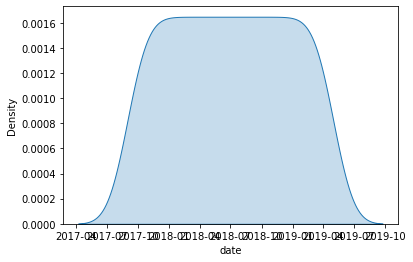

In [ ]:
for i in range(len(df.columns)):
  plt.figure()
  sns.kdeplot(df[df.columns[i]], label = df.columns[i], shade = True)

In [ ]:
df.corr()

,x1,x2,x16,x17,x26,x27,x28,x32,x34,x35,x37,x38,x39,x43,x44,x45,y1
x1,1.00000,0.00210,0.13935,0.23951,0.02788,-0.08004,-0.14358,0.43713,0.01598,-0.24705,-0.16892,0.37481,-0.17322,-0.20001,-0.27739,0.36856,0.08451
x2,0.00210,1.00000,0.31706,-0.04887,0.05335,0.15360,0.13413,-0.16828,-0.03923,0.28305,0.15973,-0.01531,0.20350,0.18120,0.24857,-0.18559,0.22975
x16,0.13935,0.31706,1.00000,0.39670,0.04483,0.04329,-0.01515,0.06332,0.13932,0.15442,0.04826,0.00899,0.01225,-0.04973,0.05794,0.01016,0.10638
x17,0.23951,-0.04887,0.39670,1.00000,-0.03143,0.10773,-0.04509,0.20209,-0.01179,-0.08490,-0.02255,0.29031,0.01991,-0.14501,-0.04694,0.34194,0.04666
x26,0.02788,0.05335,0.04483,-0.03143,1.00000,-0.43144,0.01707,0.19631,0.25397,-0.59350,-0.40955,-0.16479,-0.12643,-0.68579,-0.49493,0.10703,0.12087
x27,-0.08004,0.15360,0.04329,0.10773,-0.43144,1.00000,0.34158,0.17497,-0.28890,0.68109,0.49700,0.43256,0.39537,0.60660,0.58256,0.08706,0.21334
x28,-0.14358,0.13413,-0.01515,-0.04509,0.01707,0.34158,1.00000,0.12780,-0.15818,0.21906,0.16426,0.09994,0.43547,0.22845,0.23036,-0.17940,0.14439
x32,0.43713,-0.16828,0.06332,0.20209,0.19631,0.17497,0.12780,1.00000,-0.11803,-0.20448,-0.19300,0.40919,0.16565,-0.02762,-0.16537,0.46480,0.15177
x34,0.01598,-0.03923,0.13932,-0.01179,0.25397,-0.28890,-0.15818,-0.11803,1.00000,-0.14142,0.03662,-0.12393,-0.23565,-0.52023,-0.20512,0.19006,-0.13476
x35,-0.24705,0.28305,0.15442,-0.08490,-0.59350,0.68109,0.21906,-0.20448,-0.14142,1.00000,0.66490,0.07993,0.37419,0.71439,0.63027,-0.22298,-0.04227


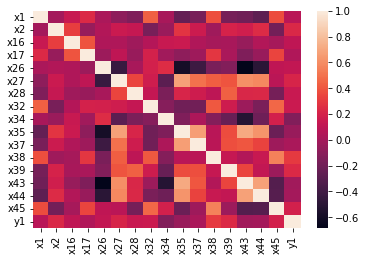

In [ ]:
sns.heatmap(df.corr())

###Run regression results to review p-values for data reduction only

In [ ]:
df.drop(columns = ['date'], inplace = True)

In [ ]:
# add column of 1's to estimate intercept parameter
df = sm.add_constant(df) 

# define Y
Y = df[[KPI_COL]]
X = df[df.columns[df.columns != KPI_COL]]
# run OLS model using statsmodels package for p-values
model = sm.OLS(Y, X)
results = model.fit()
predictions = model.predict(results.params) 

print_model = results.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y1   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     14.89
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           2.54e-34
Time:                        18:43:05   Log-Likelihood:                -4481.3
No. Observations:                 607   AIC:                             8997.
Df Residuals:                     590   BIC:                             9072.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1788.5294    150.367     11.894      0.000    1493.209    2083.849
x1           -10.8044    129.468     -0.083      0.934    -265.079     243.471
x2           687.9654    165.948      4.146      0.000     362.044    1013.887
x16          334.0348     81.711      4.088      0.000     173.555     494.514
x17         -585.0863    158.481     -3.692      0.000    -896.343    -273.830
x26          143.4115     86.208      1.664      0.097     -25.900     312.723
x27          668.3915    134.510      4.969      0.000     404.215     932.568
x28           29.7448    280.841      0.106      0.916    -521.825     581.315
x32         -467.0796    165.043     -2.830      0.005    -791.223    -142.936
x34         -223.1418    101.661     -2.195      0.029    -422.804     -23.480
x35         -926.6412    167.712     -5.525      0.000   -1256.026    -597.256
x37           54.0624    160.822      0.336      0.737    -261.790     369.915
x38          431.7154    109.574      3.940      0.000     216.513     646.917
x39          470.4980    104.528      4.501      0.000     265.207     675.789
x43           35.0865    163.935      0.214      0.831    -286.880     357.054
x44          -42.0241    154.387     -0.272      0.786    -345.239     261.191
x45          409.6695    174.023      2.354      0.019      67.889     751.450
==============================================================================
Omnibus:                       27.805   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.390
Skew:                           0.526   Prob(JB):                     2.52e-07
Kurtosis:                       3.308   Cond. No.                         36.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Implement FINAL feature selection logic based on analysis of above results

Set your p-Value threshold. This removes features with P values greater than the threshold below. For example: 
*   p-Value <= .1 / 90% significance 

In [ ]:
#@title Input p-Value threshold
P_THRESHOLD =  .1 #@param {type: "number"}

In [ ]:
# FINAL feature selection/data reduction
results_df = (results.summary2().tables[1])
sig_input = list(results_df[results_df['P>|t|']<=P_THRESHOLD].index)[1:]
X_inputs = df[sig_input] 
#X_inputs = X_transform_stand
X_inputs.columns


Index(['x2', 'x16', 'x17', 'x26', 'x27', 'x32', 'x34', 'x35', 'x38', 'x39',
       'x45'],
      dtype='object')

## Steps 4 & 5 Reduce Feature Set (Optional)

Feature selection methods if > 50 inputs remain after 3-step data reduction process

In [ ]:
#featureset_df.describe()

In [ ]:
#len(featureset_df.columns)

###Step 4: KBest

Top features based on univariate testing


In [ ]:
#k_best = SelectKBest(f_regression, k=len(X_inputs.columns))
#k_best.fit_transform(X_inputs, Y)

###Step 5: Recursive Feature Elimination (RFE)

Rank features based on recursive model testing

In [ ]:
#lm = LinearRegression()
#rfe = RFE(lm, 1)
#X_rfe = rfe.fit_transform(X_inputs,Y)
#lm.fit(X_rfe,Y)

Output results of optional feature selection process

In [ ]:
# create dataframe with KBest and RFE results
#opt_datared_df = pd.DataFrame({'feature': X_inputs.columns, 'p_value': k_best.pvalues_, 'rfe_rank': rfe.ranking_}).sort_values('p_value')
#opt_datared_df

#### Implement OPTIONAL feature selection logic based on analysis of above results
Set your p-Value threshold. For example: 
*   p-Value <= .1 / 90% significance OR
*   top 75%+ of ranking (e.g. top 15 of total 20)


In [ ]:
#@title Input p-Value and rank thresholds
#P_THRESHOLD_OPT =  .1 #@param {type: "number"}
#RANK_THRESHOLD =  1 #@param {type: "number"}

In [ ]:
# OPTIONAL feature selection/data reduction

#opt_reduction = opt_datared_df[((opt_datared_df['p_value']<=P_THRESHOLD_OPT) | 
                             #(opt_datared_df['rfe_rank'] <= RANK_THRESHOLD))] 

In [ ]:
# create list of FINAL model inputs, overwriting previous input feature list.
#opt_inputs =[]   

#for index, rows in opt_reduction.iterrows(): # iterate over each row 
#    opt_inputs.append(rows.feature) 

#X_inputs = X_inputs[opt_inputs]

# Compile Final Dataset

In [ ]:
data = X_inputs
data[KPI_COL] = Y
data['date'] = cols_to_keep['date']
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,x2,x16,x17,x26,x27,x32,x34,x35,x38,x39,x45,y1,date
0,0.27060,0.72711,0.37304,0.87324,0.33834,0.87389,0.37422,0.35818,0.77426,0.71201,0.91278,2258,2017-09-04 00:00:00+00:00
1,0.36515,0.75835,0.36868,0.89422,0.54359,0.96884,0.34698,0.33894,0.75708,0.72979,0.98093,3140,2017-09-05 00:00:00+00:00
2,0.30568,0.71697,0.52139,0.87164,0.52402,0.76018,0.41015,0.34844,0.68175,0.68754,0.87586,2253,2017-09-08 00:00:00+00:00
3,0.27530,0.71782,0.50242,0.81122,0.50405,0.74356,0.43076,0.39147,0.76627,0.19630,0.89146,1888,2017-09-09 00:00:00+00:00
4,0.37438,0.72711,0.53366,0.92894,0.48125,0.71401,0.36319,0.39172,0.79924,0.76372,0.91105,1623,2017-09-10 00:00:00+00:00


# Visualize Target Variable and Features

In [ ]:
len(data.columns)

13

In [ ]:
data.columns

Index(['x2', 'x16', 'x17', 'x26', 'x27', 'x32', 'x34', 'x35', 'x38', 'x39',
       'x45', 'y1', 'date'],
      dtype='object')

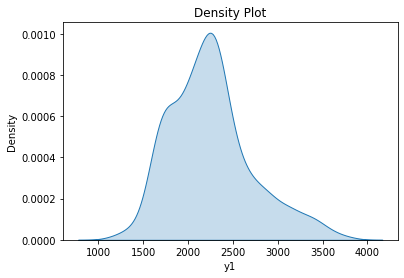

In [ ]:
sns.kdeplot(data[KPI_COL], label = KPI_COL, shade = True)
plt.xlabel(KPI_COL); plt.ylabel('Density'); plt.title('Density Plot');

Plot some features

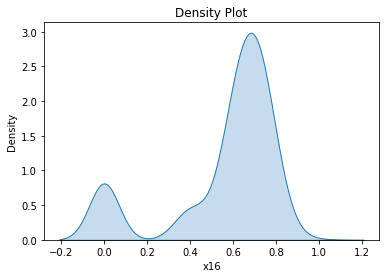

In [ ]:
sns.kdeplot(data[data.columns[1]], label = '', shade = True)
plt.xlabel(data.columns[1]); plt.ylabel('Density'); plt.title('Density Plot');

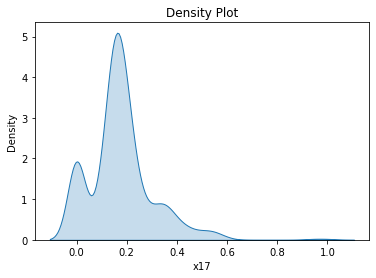

In [ ]:
sns.kdeplot(data[data.columns[2]], label = '', shade = True)
plt.xlabel(data.columns[2]); plt.ylabel('Density'); plt.title('Density Plot');

Look at relationship of individual features with target data

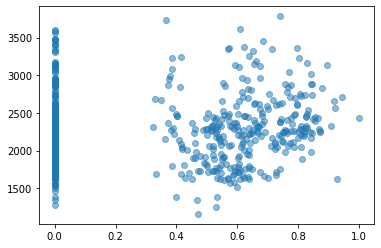

In [ ]:
plt.plot(data[data.columns[3]], data['y1'],'o',alpha=0.5)
plt.show()

# Additional Considerations

## Time Lags

- Does media on Day 1 impact conversions on Day 2?

## Diminishing Returns

- Large increases in spend do not necessarily result in 1:1 increases in conversions

## External Factors

- Are there peak seasonal periods that should be accounted for? (i.e. flags for special promotions, creatives, price changes in parket)

## L1 Regularization

- A systematic way to remove insignificant inputs and prevent overfitting 

# Export Data

In [ ]:
#@title Name data export sheet

# Naming for final data export
SHEET_NAME = 'model input data 11.02.21' #@param {type:"string"}
TAB_NAME = 'results' #@param {type:"string"}

In [ ]:
# create new spreadsheet
gc = gspread.authorize(GoogleCredentials.get_application_default())
sh = gc.create(SHEET_NAME)

# generate link for file 
SHEET_URL = "https://docs.google.com/spreadsheets/d/"+sh.id
print("Sheet URL is " + SHEET_URL)

Sheet URL is https://docs.google.com/spreadsheets/d/1uIZI_9gcs2y175jJQIJedncobpWhtSoOutOsMF8xoI4


In [ ]:
worksheet = sh.add_worksheet(title= TAB_NAME, rows=len(data), cols=len(data.columns))
set_with_dataframe(worksheet, data)